In [ ]:
try: 
    from astra.torch.models import EfficientNetClassifier
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA

In [2]:
from astra.torch.models import EfficientNetClassifier
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn

import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import umap
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /root/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset= load_cifar_10()
dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 79519425.84it/s]


Extracting /root/.cache/torch/data/cifar-10-python.tar.gz to /root/.cache/torch/data
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

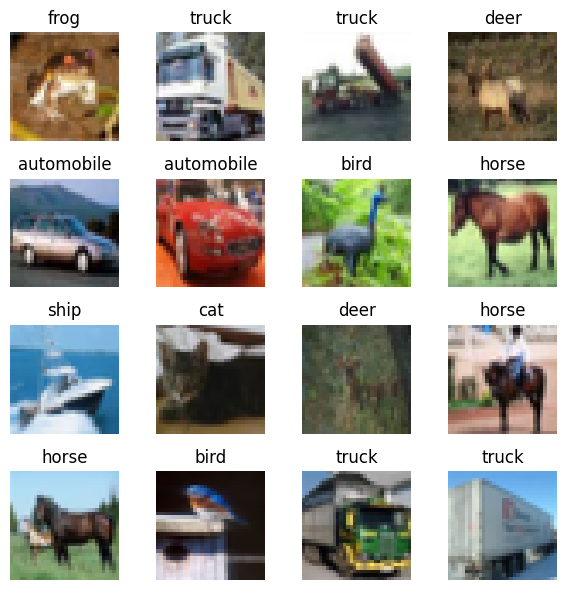

In [49]:
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis("off")
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [5]:
import math
n_train= math.floor(60000*(0.05))
n_test= math.floor(60000*(0.50))

X= dataset.data
y= dataset.targets
#print(X[0])
print(X.shape, X.dtype)
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32]) torch.float32
torch.Size([60000]) torch.int64


In [6]:
torch.manual_seed(0)
idx= torch.randperm(len(X))
train_idx= idx[:n_train]
pretrain_idx= idx[n_train:-n_test]
test_idx= idx[-n_test:]
print(len(train_idx), len(pretrain_idx), len(test_idx))

3000 27000 30000


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
efficientnet= EfficientNetClassifier(models.efficientnet_b0, models. EfficientNet_B0_Weights.DEFAULT, n_classes=10).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s] 


In [11]:
! pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [13]:
import torchsummary
torchsummary.summary(efficientnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              SiLU-6           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             512
      BatchNorm2d-14           [-1, 16,

In [14]:
def naive_accuracy(net,X,y):
    with torch.no_grad():
        logits_pred= net(X)
        y_pred= logits_pred.argmax(dim=1)
        acc= (y_pred==y).float().mean()
        return y_pred, acc

def predict(net, classes):
    for i, (name, idx) in enumerate(zip(("train","pretrain","test"), [train_idx, pretrain_idx, test_idx])):
        X_dataset= X[idx].to(device)
        y_dataset= y[idx].to(device)
        y_pred,acc= naive_accuracy(net, X_dataset, y_dataset)
        print(f'{name} accuracy: {acc*100:.2f}%')
    
predict(efficientnet, dataset.classes)

train accuracy: 9.73%
pretrain accuracy: 10.14%
test accuracy: 9.95%


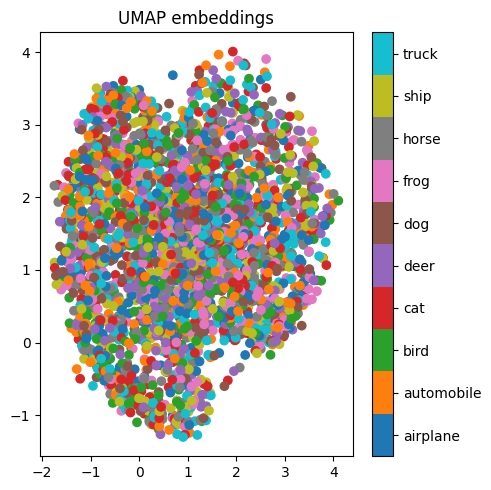

In [15]:
def viz_embeddings(net, X, y, device):
    reducer= umap.UMAP()
    with torch.no_grad():
        emb= net.featurizer(X.to(device))
    emb= emb.cpu().numpy()
    emb= reducer.fit_transform(emb)
    plt.figure(figsize=(5,5))
    plt.scatter(emb[:,0], emb[:,1], c=y.cpu().numpy(), cmap='tab10')
    cb= plt.colorbar(boundaries= np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()
    
viz_embeddings(efficientnet, X[train_idx], y[train_idx], device)

In [16]:
efficientnet = EfficientNetClassifier(models.efficientnet_b0, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)


iter_losses, epoch_losses = train_fn(efficientnet, loss_fn= nn.CrossEntropyLoss(), input= X[train_idx], output= y[train_idx], lr=3e-4, epochs=30, batch_size=128)


Loss: 0.21286994: 100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


In [17]:
print(len(iter_losses),len(epoch_losses))

720 30


Text(0, 0.5, 'Training Loss')

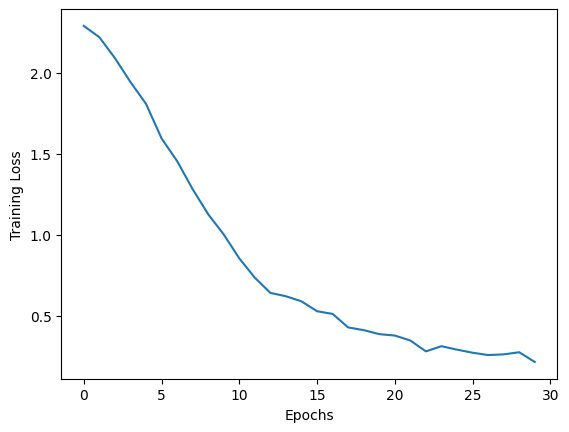

In [18]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Loss')

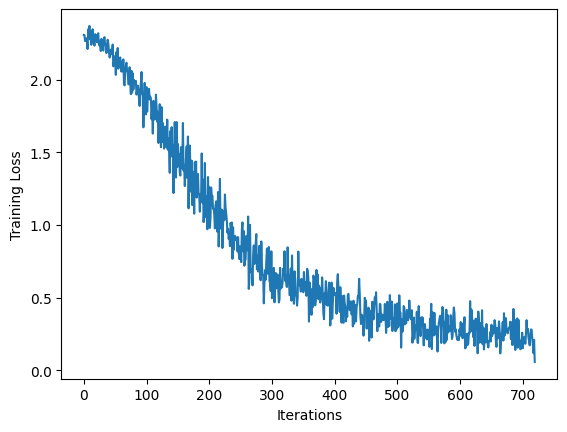

In [19]:
plt.plot(iter_losses)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")

In [20]:
predict(efficientnet, dataset.classes)

train accuracy: 90.20%
pretrain accuracy: 25.32%
test accuracy: 25.25%


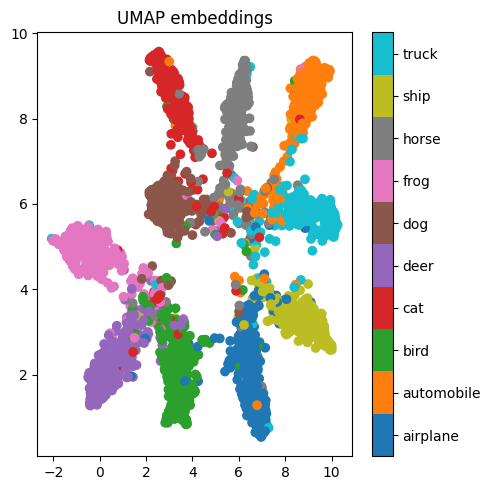

In [21]:
viz_embeddings(efficientnet, X[train_idx], y[train_idx], device)

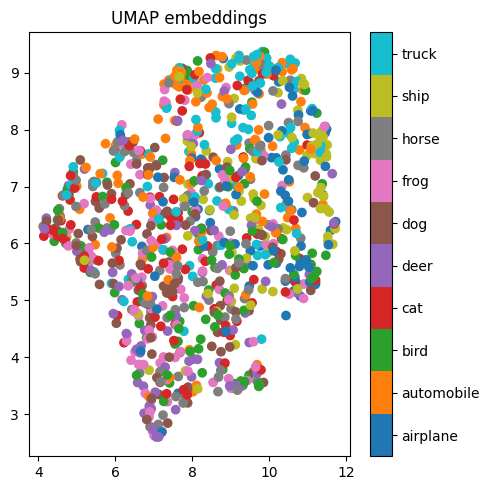

In [22]:
viz_embeddings(efficientnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [23]:
train_plus_pretrain_idx = torch.cat([train_idx, pretrain_idx])

In [24]:
efficientnet = EfficientNetClassifier(models.efficientnet_b0, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(efficientnet, loss_fn= nn.CrossEntropyLoss(), input= X[train_plus_pretrain_idx], output= y[train_plus_pretrain_idx], lr=3e-4, epochs=30, batch_size=1024)

# train_fn(model: torch.nn.Module, loss_fn: callable, input: Optional[torch.Tensor]=None, output: Optional[torch.Tensor]=None, dataloader: Optional[DataLoader]=None, lr: Optional[float]=0.01, epochs: int=1, batch_size: Optional[int]=None, optimizer: Optional[torch.optim.Optimizer]=None, model_kwargs: dict={}, loss_fn_kwargs: dict={}, shuffle: bool=False, verbose: bool=True, return_state_dict: bool=False, wandb_log: bool=False)
# Train a model with a loss function.

Loss: 0.51265794: 100%|██████████| 30/30 [02:58<00:00,  5.95s/it]


In [25]:
predict(efficientnet, dataset.classes)

train accuracy: 81.53%
pretrain accuracy: 80.83%
test accuracy: 39.93%


**Second-task**

**Implement “Image Jigsaw Puzzle” SSL on CIFAR-10 dataset**

In [39]:
X_jigsaw = []
y_jigsaw = []
X = X.to(device)
# Define the original list
original_list = [1, 2, 3, 4]

# Dictionary to store shuffled lists
patch_lists = {}

# Shuffle the list 5 times
for i in range(1, 6):
    patch_list = original_list[:]  # Copy the original list
    random.shuffle(patch_list)     # Shuffle the copied list
    patch_lists[i] = patch_list  # Store shuffled list in the dictionary
    
X_train = X[train_idx].to(device)
# Get image dimensions
batch_size, channels, height, width = X[pretrain_idx].size()

# Calculate patch dimensions
patch_height = height // 2
patch_width = width // 2

for key, patch_list in patch_lists.items():
    processed_samples = []
    for i in range(batch_size):
        # Initialize list to store patches
        patches = []

        # Break image into patches
        for row in range(2):
            for col in range(2):
                start_h = row * patch_height
                end_h = start_h + patch_height
                start_w = col * patch_width
                end_w = start_w + patch_width
                patch = X[pretrain_idx][i, :, start_h:end_h, start_w:end_w].clone()
                patches.append(patch)

        # Reorder patches based on patch list
        ordered_patches = [patches[idx-1] for idx in patch_list]

        # Concatenate patches along columns
        output_1 = torch.cat(ordered_patches[:2], dim=2)
        output_2= torch.cat(ordered_patches[2:4], dim=2)
        whole_image = torch.cat([output_1, output_2], dim=1)
        processed_samples.append(whole_image)
        if i%500==0:
            print(i)

    # Store processed image tensors for the current key
    processed_images = torch.stack(processed_samples).to(device)

    X_jigsaw.append(processed_images)
    y_jigsaw.append(torch.tensor([key-1]*len(processed_images), device=device))


X_jigsaw = torch.cat(X_jigsaw).to(device)
y_jigsaw = torch.cat(y_jigsaw).to(device)    

print(X_jigsaw.shape, X_jigsaw.dtype)
print(y_jigsaw.shape, y_jigsaw.dtype)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
0
500
1000
1500
2000
2500
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16

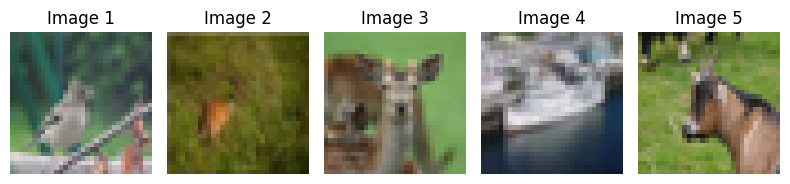

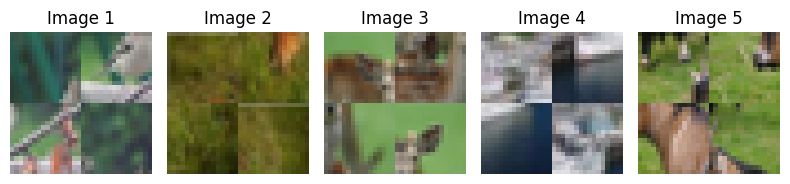

In [52]:
# Function to visualize images
def visualize_images(images, num_images=5):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 8))

    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f'Image {i+1}')  # Set title for each image

    plt.tight_layout()  # Adjust layout
    plt.show()

# Visualize some images
num_images_to_visualize = 5
visualize_images(X[pretrain_idx])


def visualize_images_1(images, num_images=5):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 8))

    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f'Image {i+1}')  # Set title for each image

    plt.tight_layout()  # Adjust layout
    plt.show()

# Visualize some images
num_images_to_visualize = 5
visualize_images_1(X_jigsaw[81000:81005])

In [51]:
for key, patch_list in patch_lists.items():
    print(patch_list)

[3, 2, 1, 4]
[1, 2, 3, 4]
[4, 2, 3, 1]
[1, 3, 4, 2]
[4, 2, 3, 1]


In [41]:
jigsaw= EfficientNetClassifier(models.efficientnet_b0, None, n_classes=5, activation= nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses= train_fn(jigsaw, loss_fn= nn.CrossEntropyLoss(), input= X_jigsaw, output= y_jigsaw, 
                                    lr=0.005, batch_size= 1024, epochs=10)


Loss: 1.47884920: 100%|██████████| 10/10 [04:24<00:00, 26.42s/it]


Text(0, 0.5, 'Training Loss')

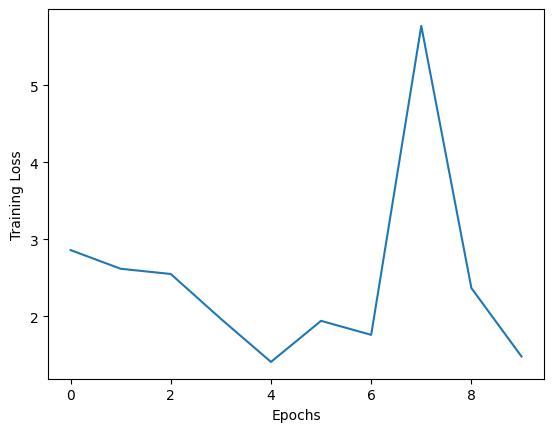

In [42]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

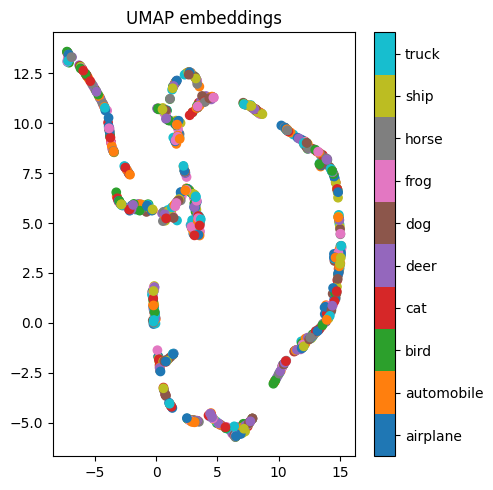

In [54]:
viz_embeddings(jigsaw, X[pretrain_idx[:1000]], y[pretrain_idx[:1000]], device)

In [44]:
net_pretrained= EfficientNetClassifier(models.efficientnet_b0, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
net_pretrained.featurizer.load_state_dict(jigsaw.featurizer.state_dict())

iter_losses, epoch_losses= train_fn(net_pretrained, loss_fn= nn.CrossEntropyLoss(), input=X[train_idx], output=y[train_idx], 
                                    lr=0.005, batch_size= 128, epochs=50)


Loss: 1.01924319: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Text(0, 0.5, 'Training Loss')

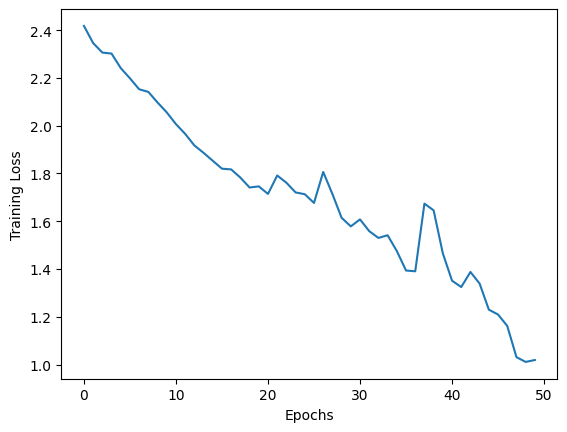

In [45]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

In [46]:
predict(net_pretrained, dataset.classes)

train accuracy: 49.30%
pretrain accuracy: 30.33%
test accuracy: 30.71%
